In [89]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy
from astropy.io import fits
from matplotlib import rcParams
from astropy.wcs import WCS 
from pathlib import Path
from reproject import reproject_interp
import sep
#import fitsio
import photutils
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
rcParams['figure.figsize'] = [12., 12.]
from scipy.spatial import cKDTree
from astropy.coordinates import SkyCoord
import astropy.units as u

In [90]:


#https://docs.astropy.org/en/stable/io/fits/index.html
# https://stackoverflow.com/questions/21583647/reading-headers-from-multiple-fits-file-from-the-same-directory


directory = Path(r'C:\Users\Pablo\StarClusters\Nickel_fits_April13_2023')

fits_files = [f for f in directory.iterdir() if f.suffix.lower() == '.fits']
image_data = []
image_headers = []
records=[]

for f in fits_files:
    with fits.open(f) as hdul:
        data = hdul[0].data
        header = hdul[0].header
        wcs = WCS(header)

        image_data.append(data)
        image_headers.append(header)
        records.append((f, data, header, wcs))

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60048.027143 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.027516 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.027889 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.028262 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.028635 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.029008 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.029380 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.029753 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.030126 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.030499 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.045498 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.046395 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.047292 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.048190 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.049087 from DATE-END'. [astropy.wcs.wcs]
Se

Set MJD-END to 60048.258210 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.259975 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.263574 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.265340 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.269563 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.271328 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.273094 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.274859 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.276624 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.279652 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.280722 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.281793 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.282864 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.283935 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.293035 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60048.295148 from DATE-END'. [astropy.wcs.wcs]
Set MJD-

In [91]:
#https://stackoverflow.com/questions/21583647/reading-headers-from-multiple-fits-file-from-the-same-directory
#https://www.w3schools.com/python/ref_string_startswith.asp

bias = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 100 <= int(f.stem.split('d')[-1]) <= 109
]

domeflatB = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 110 <= int(f.stem.split('d')[-1]) <= 114
]

domeflatV = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 115 <= int(f.stem.split('d')[-1]) <= 119
]

domeflatR = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 120 <= int(f.stem.split('d')[-1]) <= 124
]


In [92]:
rawB = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 156 <= int(f.stem.split('d')[-1]) <= 160
]
rawV = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 161 <= int(f.stem.split('d')[-1]) <= 165
]
rawR = [
    data for f, data in zip(fits_files, image_data)
    if f.stem.startswith('d') and 166 <= int(f.stem.split('d')[-1]) <= 170  
]

In [93]:
#data type dictates where the party goes
print(type(rawB))

<class 'list'>


In [94]:
master_bias=np.median(np.stack(bias),axis=0)

def domecal(filt, bias):
    clean = [flat - bias for flat in filt] 
    master_dome= np.mean(clean, axis=0)
    return master_dome/np.mean(master_dome)

def scical(sci, flat):
    cleaned_images = []
    for image in sci:
        # Subtract bias
        corrected = image - master_bias

        # Divide by normalized flat
        cleaned = corrected / flat

        cleaned_images.append(cleaned)
    
    return cleaned_images

In [95]:
normdomB=domecal(domeflatB,master_bias)
normdomV=domecal(domeflatV,master_bias)
normdomR=domecal(domeflatR,master_bias)

In [96]:
cleaned_sci_imagesB = scical(rawB, normdomB)
cleaned_sci_imagesV = scical(rawV, normdomV)
cleaned_sci_imagesR = scical(rawR, normdomR)

<ipython-input-94-dff4735d0e34>:15: RuntimeWarning: divide by zero encountered in divide
  cleaned = corrected / flat
<ipython-input-94-dff4735d0e34>:15: RuntimeWarning: invalid value encountered in divide
  cleaned = corrected / flat


In [97]:
 # Clean science frames with only bias correction
# def scical_bias_only(sci, master_bias):
#     cleaned_images = []
#     for image in sci:
#         corrected = (image - master_bias).astype(np.float32)
#         cleaned_images.append(corrected)
#     return cleaned_images



In [98]:
# cleaned_sci_imagesB = bias_only_scical(rawB, normdomB)
# cleaned_sci_imagesV = bias_only_scical(rawV, normdomV)
# cleaned_sci_imagesR = bias_only_scical(rawR, normdomR)

# Key the data

In [99]:
science_images = {
    'B': cleaned_sci_imagesB,
    'V': cleaned_sci_imagesV,
    'R': cleaned_sci_imagesR
}

In [100]:
bias_headers = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 100 <= int(f.stem.split('d')[-1]) <= 109
]
domeflatB_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 110 <= int(f.stem.split('d')[-1]) <= 114
]
domeflatV_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 115 <= int(f.stem.split('d')[-1]) <= 119
]
domeflatR_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 120 <= int(f.stem.split('d')[-1]) <= 124
]
rawB_header = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 156 <= int(f.stem.split('d')[-1]) <= 160
]
rawV_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 161 <= int(f.stem.split('d')[-1]) <= 165
]
rawR_header  = [
    header for f, header in zip(fits_files, image_headers)
    if f.stem.startswith('d') and 166 <= int(f.stem.split('d')[-1]) <= 170
]

In [101]:
calibB = [data for f, data in zip(fits_files, image_data) if 126 <= int(f.stem.split('d')[-1]) <= 130]
calibV = [data for f, data in zip(fits_files, image_data) if 131 <= int(f.stem.split('d')[-1]) <= 135]
calibR = [data for f, data in zip(fits_files, image_data) if 136 <= int(f.stem.split('d')[-1]) <= 140]

calibB_headers = [header for f, header in zip(fits_files, image_headers) if 126 <= int(f.stem.split('d')[-1]) <= 130]
calibV_headers = [header for f, header in zip(fits_files, image_headers) if 131 <= int(f.stem.split('d')[-1]) <= 135]
calibR_headers = [header for f, header in zip(fits_files, image_headers) if 136 <= int(f.stem.split('d')[-1]) <= 140]

stacked_calibB = np.median(np.stack(calibB), axis=0)
stacked_calibV = np.median(np.stack(calibV), axis=0)
stacked_calibR = np.median(np.stack(calibR), axis=0)


In [102]:
# from astropy.wcs import WCS
# from astropy.io import fits



# # Let's use the first calibration B header as an example
# header = calibB_headers[0]  # You can change the index if needed

# # Extract the WCS and reference coordinates
# w = WCS(header)
# ra_center, dec_center = w.wcs.crval  # RA and DEC in degrees

# print(f"Calibration star pointing center:\nRA = {ra_center:.6f}, DEC = {dec_center:.6f}")


In [103]:
# for i, header in enumerate(calibB_headers):
#     w = WCS(header)
#     ra, dec = w.wcs.crval
#     print(f"Image {i+1}: RA = {ra:.6f}, DEC = {dec:.6f}")


In [104]:
# print(calibB_headers)

In [105]:
print(image_headers[0])

SIMPLE  =                    T / NORMAL FITS IMAGE                              BITPIX  =                   16 / DATA PRECISION                                 NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     NAXIS1  =                 1056 / NUMBER OF COLUMNS                              NAXIS2  =                 1024 / NUMBER OF ROWS                                 CRVAL1U =                 2048 / COLUMN ORIGIN                                  CRVAL2U =                 2048 / ROW ORIGIN                                     CDELT1U =                   -2 / COLUMN CHANGE PER PIXEL                        CDELT2U =                   -2 / ROW CHANGE PER PIXEL                           OBSNUM  =                  100 / OBSERVATION NUMBER                             IDNUM   =                    2 / IMAGE ID                                       UGEOM   =                    0 / UCAM READOUT GEOMETRY                          DGEOM   =                    0 / DESCRAM

In [106]:
ref_wcs = WCS(rawB_header[0]) # or rawB_header[0]

def align_stack(cleaned_images, headers):
    aligned = []
    for img, hdr in zip(cleaned_images, headers):
        array, _ = reproject_interp((img, WCS(hdr)), ref_wcs)
        aligned.append(array)
    return np.median(np.stack(aligned), axis=0)

stacked_B = align_stack(cleaned_sci_imagesB, rawB_header)
stacked_V = align_stack(cleaned_sci_imagesV, rawV_header)
stacked_R = align_stack(cleaned_sci_imagesR, rawR_header)



In [107]:
# print("B stack:", "min:", np.nanmin(stacked_B), "max:", np.nanmax(stacked_B), "NaNs:", np.isnan(stacked_B).sum())
# print("V stack:", "min:", np.nanmin(stacked_V), "max:", np.nanmax(stacked_V), "NaNs:", np.isnan(stacked_V).sum())
# print("R stack:", "min:", np.nanmin(stacked_R), "max:", np.nanmax(stacked_R), "NaNs:", np.isnan(stacked_R).sum())


In [108]:
# print("cleaned_sci_imagesB[0]:", np.nanmin(cleaned_sci_imagesB[0]), np.nanmax(cleaned_sci_imagesB[0]))


In [109]:
# img = safe_clean(cleaned_sci_imagesB[0])
# reprojected, footprint = reproject_interp((img, WCS(rawB_header[0])), ref_wcs)

# print("Reprojected image stats:")
# print("min:", np.nanmin(reprojected), "max:", np.nanmax(reprojected), "nan count:", np.isnan(reprojected).sum())

# print("Footprint stats (should be >0 where valid):")
# print("min:", np.nanmin(footprint), "max:", np.nanmax(footprint))


In [110]:
# print("ref_wcs info:")
# print(ref_wcs)

# print("target_wcs info:")
# print(WCS(rawB_header[0]))  # Or whichever you test


In [111]:
# print(len(stacked_B))
# print("min:", np.min(stacked_B))
# print("max:", np.max(stacked_B))
# print("mean:", np.mean(stacked_B))
# print("nan count:", np.isnan(stacked_B).sum())


In [112]:
# plt.imshow(stacked_B, origin='lower', cmap='gray', vmin=np.percentile(stacked_B, 5), vmax=np.percentile(stacked_B, 99))
# plt.title("Stacked B Image")
# plt.colorbar()
# plt.show()


In [113]:
def photometry(data, thresh=1.0, minarea=10):
    data = np.nan_to_num(data.astype(np.float32))
    bkg = sep.Background(data)
    data_sub = data - bkg.back()
    objects = sep.extract(data_sub, thresh=thresh, minarea=minarea)

    if len(objects) == 0:
        raise ValueError("No sources found in image. Try lowering the threshold or checking image quality.")

    x = objects['x'].astype(float)
    y = objects['y'].astype(float)
    positions = np.column_stack((x, y))

    aperture = CircularAperture(positions, r=3.0)
    phot_table = aperture_photometry(data, aperture)
    phot_table['xcenter'] = x
    phot_table['ycenter'] = y

    return phot_table, objects


phot_tableB, objectsB = photometry(stacked_B)
phot_tableV, objectsV = photometry(stacked_V)
phot_tableR, objectsR = photometry(stacked_R)


In [114]:
print(len(phot_tableB))


6780


In [120]:
from scipy.spatial import cKDTree

# Extract coordinates from photometry tables
coords_B = np.column_stack((phot_tableB['xcenter'], phot_tableB['ycenter']))
coords_V = np.column_stack((phot_tableV['xcenter'], phot_tableV['ycenter']))
coords_R = np.column_stack((phot_tableR['xcenter'], phot_tableR['ycenter']))

# Build KD-trees
tree_V = cKDTree(coords_V)
tree_R = cKDTree(coords_R)

# Match B to V and B to R
max_sep = 3.0  # pixel distance tolerance for matching

dist_BV, idx_BV = tree_V.query(coords_B, distance_upper_bound=max_sep)
dist_BR, idx_BR = tree_R.query(coords_B, distance_upper_bound=max_sep)

# Only keep good matches (where distance is below threshold)
valid_BV = dist_BV < max_sep
valid_BR = dist_BR < max_sep
valid_all = valid_BV & valid_BR

# Final matched indices
idx_B = np.where(valid_all)[0]
idx_V = idx_BV[valid_all]
idx_R = idx_BR[valid_all]


In [121]:
matched_B = phot_tableB[idx_B]
matched_V = phot_tableV[idx_V]
matched_R = phot_tableR[idx_R]

combined_catalog = pd.DataFrame({
    'x': matched_B['xcenter'],
    'y': matched_B['ycenter'],
    'flux_B': matched_B['aperture_sum'],
    'flux_V': matched_V['aperture_sum'],
    'flux_R': matched_R['aperture_sum']
})


In [122]:
# Exposure times (in seconds)
exp_B = 120
exp_V = 120
exp_R = 60

# Convert flux to instrumental magnitudes
mag_B = -2.5 * np.log10(combined_catalog['flux_B']) + 2.5 * np.log10(exp_B)
mag_V = -2.5 * np.log10(combined_catalog['flux_V']) + 2.5 * np.log10(exp_V)
mag_R = -2.5 * np.log10(combined_catalog['flux_R']) + 2.5 * np.log10(exp_R)


In [123]:
combined_catalog['mag_B'] = mag_B
combined_catalog['mag_V'] = mag_V
combined_catalog['mag_R'] = mag_R
combined_catalog['B-V'] = mag_B - mag_V
combined_catalog['V-R'] = mag_V - mag_R


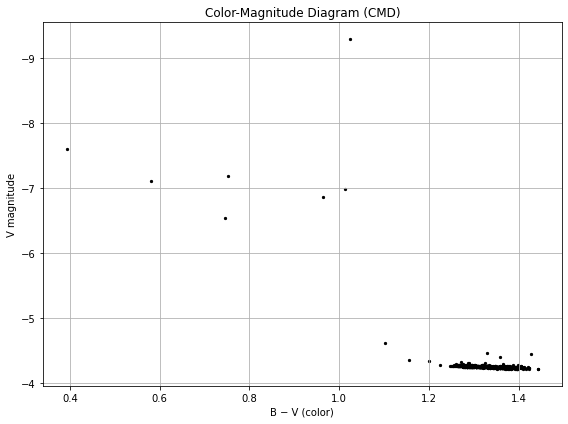

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(combined_catalog['B-V'], combined_catalog['mag_V'], s=5, color='black')
plt.gca().invert_yaxis()
plt.xlabel('B − V (color)')
plt.ylabel('V magnitude')
plt.title('Color-Magnitude Diagram (CMD)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# positive_flux = (
#     (combined_catalog['flux_B'] > 0) &
#     (combined_catalog['flux_V'] > 0) &
#     (combined_catalog['flux_R'] > 0)
# )
# combined_catalog = combined_catalog[positive_flux]
# # 

In [118]:
# data = stacked_B.astype(np.float32)
# data = np.nan_to_num(data)
# bkg = sep.Background(data)
# data_sub = data - bkg.back()

# plt.imshow(data_sub, cmap='gray', origin='lower', vmin=np.percentile(data_sub, 5), vmax=np.percentile(data_sub, 99))
# plt.title("Background-subtracted stacked_B")
# plt.colorbar()
# plt.show()


In [ ]:
import pandas as pd
import gzip

isochrone_file = 'isoc_z019.dat.gz'

# Read gzipped isochrone file
with gzip.open(isochrone_file, 'rt') as f:
    lines = f.readlines()

# Extract only the rows containing actual data (skip headers)
data_lines = [line for line in lines if not line.startswith('#') and len(line.strip().split()) > 5]

# Convert to DataFrame
columns = ['Z', 'logAge', 'Mini', 'Mass', 'Teff', 'logL', 'logg', 'Mbol', 'UBmag', 'Bmag', 'Vmag', 'Rmag', 'Imag', 'Jmag', 'Hmag', 'Kmag']
iso_data = pd.DataFrame([list(map(float, line.strip().split())) for line in data_lines], columns=columns)
